# Lesson 6: Planning and Stock Report Generation

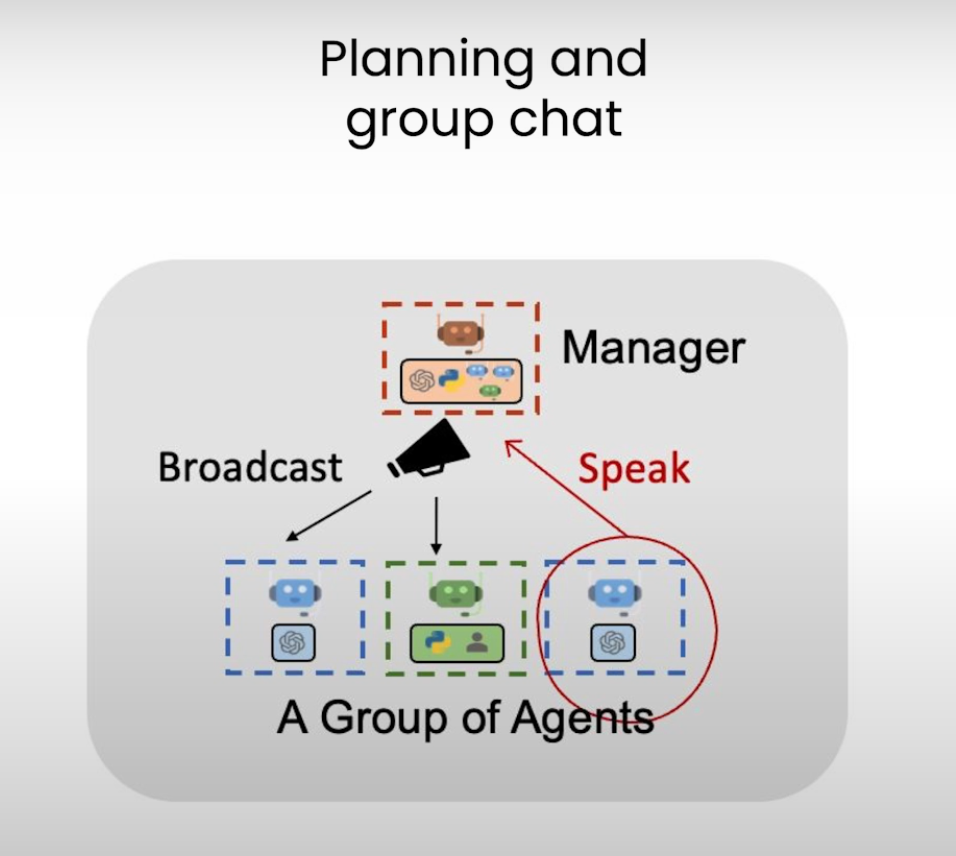

## Setup

In [1]:
llm_config={"model": "gpt-4-turbo"}

## The task!

In [2]:
# 写一篇关于英伟达过去一个月股价表现的博客文章。今天的日期是2024-04-23。
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-04-23."

## Build a group chat

This group chat will include these agents:

1. **User_proxy** or **Admin**: to allow the user to comment on the report and ask the writer to refine it.
2. **Planner**: to determine relevant information needed to complete the task.
3. **Engineer**: to write code using the defined plan by the planner.
4. **Executor**: to execute the code written by the engineer.
5. **Writer**: to write the report.

1.**User_proxy**或**Admin**：允许用户对报告进行评论，并要求编写者对其进行改进。  
2.**Planner**：确定完成任务所需的相关信息。  
3.**Engineer**：使用规划师定义的计划编写代码。  
4.**Executor**：执行工程师编写的代码。  
5.**Writer**：撰写报告。  

In [3]:
import autogen

In [26]:
#这个 agent 总会在轮到它时寻求人的意见或者获取任务，然后发送指令给写手去优化润色博文
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

##   system_message 和 description 的区别：
- system_message： 是一个指令并且仅仅告诉agent ，只有当前agent 知道
- description: 让其他agent 知道当前agent 的角色，管理者可以根据description 来决定什么时候调用当前agent

In [27]:
#  planner agent 会分解复杂任务为简单的小任务
# 然后将这些子任务发送给其他 agent 来解决它们
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)
# system_message="""给定一个任务，请确定完成任务所需的信息。
#                请注意，这些信息都将使用Python代码检索。
#                请只建议使用Python代码可以检索的信息。
#                其他人完成每个步骤后，检查进度和指示其余步骤。
#                如果某个步骤失败，请尝试解决方法"""
# description="""Planner。
#                 给定一项任务，确定完成任务所需的信息。
#                 在其他人完成每个步骤后，检查进度并指导剩余步骤"""

In [28]:
# 根据规划师(planner)提供的计划编写代码的工程师。
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

**Note**: In this lesson, you'll use an alternative method of code execution by providing a dict config. However, you can always use the LocalCommandLineCodeExecutor if you prefer. For more details about code_execution_config, check this: https://microsoft.github.io/autogen/docs/reference/agentchat/conversable_agent/#__init__

In [29]:
# 执行工程师（engineer）编写的代码并报告结果。
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,#当前agent会回看历史内容并且找到第一个包含code的message,然后执行message中的code
        "work_dir": "coding",# 存文件和中间结果的路径
        "use_docker": False,
    },
)

In [30]:
# 写手 agent
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## Define the group chat  定义群聊

In [31]:
#
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],# 初始化信息，
    max_round=10,
)

###### 创建 GroupChatManager，作为AutoGen 中一个特殊的agent来管理这个群聊

In [32]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, 
    llm_config=llm_config
)


## Start the group chat! 开始群聊了

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

In [12]:
# 用 manager 和 user_proxy 初始化群聊，因为第一条信息希望是来自user_proxy
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To complete the task of writing a blog post about the stock price performance of Nvidia in the past month, you will need to gather the following information:

1. **Stock Prices for Nvidia:**
   - Daily closing prices from March 23, 2024, to April 23, 2024. 

2. **Comparison Metrics:**
   - Analyzing key performance indicators such as highest price, lowest price, and price changes over the month.

3. **Contextual Information:**
   - Any major news or events during this period that might have influenced Nvidia's stock prices.

4. **Visualization:**
   - Graphical representation of the stock price movements over the specified period.

Here's how you can retrieve each piece of information using Python:

1. **Stock Prices


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Admin (to chat_manager):

Your analysis is well-structured and communicates the key information effectively. However, we can enhance the readability and engagement of your blog post with some additional refinements. Here are some suggestions:

1. **Add Subheadings for Better Structure:**
   Adjust subheadings to ensure they are action-oriented or question-based, which can make the post more engaging. For example, change "Performance Overview" to "How Did Nvidia’s Stock Perform?".

2. **Include Specific Dates for Important Events:**
   When referencing the highest and lowest stock prices, mention the specific dates on which these occurred. This detail adds depth to the analysis and helps readers understand the timing of market mo


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: exit


在上面的对话中，我们看到了所有的agent被group chat manager 根据agent预定义的角色和描述自动触发。agent的角色和描述需要精心设计以便他们可以遵循正确的顺序和计划。我们发现planner 执行建议和初始化计划的角色，并且在一些步骤完成后，他会review这个过程（progress）然后跟随这些步骤。但是不是所有的步骤都被真正的followed ，在一开始的两步后，我认为写手（writer）跳过了第三步然后开始写博文。这是使用语言模型来设计和说话顺序的缺点。但是你也可以加一些限制到这个对话中。例如：可以添加 speaker的顺序限制。

## Add a speaker selection policy 添加发言人顺序策略

In [4]:
# 跟之前一样重新定义一组agent
# user_proxy = autogen.ConversableAgent(
#     name="Admin",
#     system_message="Give the task, and send "
#     "instructions to writer to refine the blog post.",
#     code_execution_config=False,
#     llm_config=llm_config,
#     human_input_mode="ALWAYS",
# )
#这个 agent 总会在轮到它时寻求人的意见或者获取任务，然后发送指令给写手去优化润色博文
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

# planner = autogen.ConversableAgent(
#     name="Planner",
#     system_message="Given a task, please determine "
#     "what information is needed to complete the task. "
#     "Please note that the information will all be retrieved using"
#     " Python code. Please only suggest information that can be "
#     "retrieved using Python code. "
#     "After each step is done by others, check the progress and "
#     "instruct the remaining steps. If a step fails, try to "
#     "workaround",
#     description="Given a task, determine what "
#     "information is needed to complete the task. "
#     "After each step is done by others, check the progress and "
#     "instruct the remaining steps",
#     llm_config=llm_config,
# )

#  planner agent 会分解复杂任务为简单的小任务
# 然后将这些子任务发送给其他 agent 来解决它们
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

# engineer = autogen.AssistantAgent(
#     name="Engineer",
#     llm_config=llm_config,
#     description="Write code based on the plan "
#     "provided by the planner.",
# )
# 根据规划师(planner)提供的计划编写代码的工程师。
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

# writer = autogen.ConversableAgent(
#     name="Writer",
#     llm_config=llm_config,
#     system_message="Writer. "
#     "Please write blogs in markdown format (with relevant titles)"
#     " and put the content in pseudo ```md``` code block. "
#     "You take feedback from the admin and refine your blog.",
#     description="After all the info is available, "
#     "write blogs based on the code execution results and take "
#     "feedback from the admin to refine the blog. ",
# )
# 写手 agent
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

# executor = autogen.ConversableAgent(
#     name="Executor",
#     description="Execute the code written by the "
#     "engineer and report the result.",
#     human_input_mode="NEVER",
#     code_execution_config={
#         "last_n_messages": 3,
#         "work_dir": "coding",
#         "use_docker": False,
#     },
# )
# 执行工程师（engineer）编写的代码并报告结果。
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,#当前agent会回看历史内容并且找到第一个包含code的message,然后执行message中的code
        "work_dir": "coding",# 存文件和中间结果的路径
        "use_docker": False,
    },
)

In [22]:
#  改变的是这里！！！
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
    #下面是新增加的
    #为每一个agent定义那些agent可以在当前agent后讲话
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [23]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, 
    llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To complete the task of writing a blog post about the stock price performance of Nvidia in the past month, you will need to gather the following information:

1. **Stock Prices for Nvidia:**
   - Daily closing prices from March 23, 2024, to April 23, 2024. 

2. **Comparison Metrics:**
   - Analyzing key performance indicators such as highest price, lowest price, and price changes over the month.

3. **Contextual Information:**
   - Any major news or events during this period that might have influenced Nvidia's stock prices.

4. **Visualization:**
   - Graphical representation of the stock price movements over the specified period.

Here's how you can retrieve each piece of information using Python:

1. **Stock Prices


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Admin (to chat_manager):

Your analysis is well-structured and communicates the key information effectively. However, we can enhance the readability and engagement of your blog post with some additional refinements. Here are some suggestions:

1. **Add Subheadings for Better Structure:**
   Adjust subheadings to ensure they are action-oriented or question-based, which can make the post more engaging. For example, change "Performance Overview" to "How Did Nvidia’s Stock Perform?".

2. **Include Specific Dates for Important Events:**
   When referencing the highest and lowest stock prices, mention the specific dates on which these occurred. This detail adds depth to the analysis and helps readers understand the timing of market mo


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...


RateLimitError: Error code: 429 - {'error': {'message': 'exceeded quota for this month'}}

**Note**: You might experience slightly different interactions between the agents. The engineer agent may write incorrect code, which the executor agent will report and send back for correction. This process could go through multiple rounds.  
代理之间的交互可能略有不同。工程师代理可能会编写不正确的代码，执行人代理会报告并发回更正。这个过程可能会经历多轮。